In [1]:
import numpy as np
import pandas as pd
import wave
from scipy.io import wavfile
import shutil
import os
import librosa
from librosa.feature import melspectrogram
import warnings
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from PIL import Image
from uuid import uuid4
import sklearn
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, LSTM, SimpleRNN, Conv1D, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import Callback
import seaborn as sns

In [2]:
np.random.seed(1)
tf.random.set_seed(2)
os.environ['TF_CUDNN_DETERMINISTIC'] = 'true'
os.environ['TF_DETERMINISTIC_OPS'] = 'true'
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU not found. Using CPU.")

Default GPU Device: /device:GPU:0


In [3]:
folder_path = './Preprocessing/train_audio/'

mp3_files = []

# Walk through all directories and subdirectories
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith('.mp3'):
            mp3_files.append({'mp3_filename': file, 'Bird': os.path.relpath(root, folder_path)})

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(mp3_files)

print(df)

      mp3_filename    Bird
0     XC125512.mp3  amered
1     XC134496.mp3  amered
2     XC134499.mp3  amered
3     XC135440.mp3  amered
4     XC135462.mp3  amered
...            ...     ...
2461  XC469599.mp3  yerwar
2462  XC475039.mp3  yerwar
2463  XC475291.mp3  yerwar
2464  XC499252.mp3  yerwar
2465  XC503063.mp3  yerwar

[2466 rows x 2 columns]


In [4]:
train_df = pd.read_csv('./train.csv')
train_df = train_df.merge(df, left_on='filename', right_on='mp3_filename', how='inner')
train_df = shuffle(train_df)
len(train_df)

2466

In [5]:
birds_to_recognise = sorted(shuffle(train_df.ebird_code.unique()))
print(birds_to_recognise)

['amered', 'amewoo', 'bewwre', 'bkhgro', 'bktspa', 'brespa', 'brncre', 'buggna', 'chispa', 'comter', 'comyel', 'eastow', 'foxspa', 'gnttow', 'gockin', 'grtgra', 'hoowar', 'houfin', 'indbun', 'lesgol', 'linspa', 'logshr', 'marwre', 'norcar', 'norpar', 'norwat', 'orcwar', 'pinwar', 'purfin', 'reevir1', 'renpha', 'stejay', 'tuftit', 'veery', 'westan', 'whbnut', 'whcspa', 'whtspa', 'woothr', 'yerwar']


In [6]:
def get_sample(filename, bird, output_folder):
    wave_data, wave_rate = librosa.load(filename)
    wave_data, _ = librosa.effects.trim(wave_data)
    # Only take 3s samples and add them to the dataframe
    song_sample = []
    sample_length = 5 * wave_rate
    samples_from_file = []
    N_mels = 216  # Chosen mainly to create a 216x216 image
    
    for idx in range(0, len(wave_data), sample_length): 
        song_sample = wave_data[idx:idx+sample_length]
        if len(song_sample) >= sample_length:
            # Call melspectrogram from the librosa.feature module
            mel = librosa.feature.melspectrogram(y=song_sample, sr=wave_rate, n_mels=N_mels)
            db = librosa.power_to_db(mel)
            normalised_db = sklearn.preprocessing.minmax_scale(db)
            filename = str(uuid4()) + ".png"
            db_array = (np.asarray(normalised_db) * 255).astype(np.uint8)
            db_image = Image.fromarray(np.array([db_array, db_array, db_array]).T)
            db_image.save("{}{}".format(output_folder, filename))
            
            samples_from_file.append({
                "song_sample": "{}{}".format(output_folder, filename),
                "bird": bird
            })
    return samples_from_file

In [14]:
%%time
warnings.filterwarnings("ignore")
samples_df = pd.DataFrame(columns=["song_sample","bird"])
sample_limit = len(train_df)
sample_list = []
output_folder = './melspectrogram4_dataset/'
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.mkdir(output_folder)
with tqdm(total=sample_limit) as pbar:
    for idx, row in train_df[:sample_limit].iterrows():
        pbar.update(1)
        try:
            audio_file_path = './Preprocessing/train_audio/'
            audio_file_path += row.ebird_code
            if row.ebird_code in birds_to_recognise:
                sample_list += get_sample('{}/{}'.format(audio_file_path, row.filename), row.ebird_code, output_folder)
            else:
                sample_list += get_sample('{}/{}'.format(audio_file_path, row.filename), "nocall", output_folder)
        except:
            raise
            print("{} is corrupted".format(audio_file_path))
            
samples_df = pd.DataFrame(sample_list)
samples_df = shuffle(samples_df)
samples_df.to_csv(r'./samples_df.csv', index=False)

100%|██████████| 2466/2466 [17:26<00:00,  2.36it/s]

CPU times: total: 4min 23s
Wall time: 17min 31s


In [7]:
samples_df = pd.read_csv(r"./samples_df.csv")

In [8]:
samples_df = shuffle(samples_df)
print(samples_df.bird.value_counts())
samples_df[:10]

bird
amered     762
brespa     750
whtspa     748
marwre     734
woothr     722
gockin     700
bktspa     677
houfin     658
linspa     656
hoowar     653
foxspa     645
comyel     632
gnttow     631
buggna     627
reevir1    624
orcwar     608
comter     607
bkhgro     601
tuftit     600
veery      597
yerwar     593
brncre     591
amewoo     591
norcar     587
westan     583
indbun     577
lesgol     577
whcspa     559
bewwre     543
logshr     536
grtgra     516
whbnut     513
norwat     511
norpar     506
eastow     504
chispa     491
stejay     484
purfin     481
pinwar     386
renpha     256
Name: count, dtype: int64


,song_sample,bird
3806,./melspectrogram4_dataset/c3ecf2da-35cb-4162-b...,gnttow
21790,./melspectrogram4_dataset/e2ec8a1c-a304-4134-b...,whbnut
505,./melspectrogram4_dataset/9fb0914d-33da-42da-8...,gockin
3832,./melspectrogram4_dataset/6355ab87-ac57-44c8-b...,chispa
7052,./melspectrogram4_dataset/7685d604-cff5-4916-8...,stejay
9450,./melspectrogram4_dataset/f7d859f9-71e0-4cd2-9...,norpar
19659,./melspectrogram4_dataset/87ca6853-2f77-4f78-a...,whcspa
18371,./melspectrogram4_dataset/168f8b9d-0667-4ab2-a...,hoowar
17906,./melspectrogram4_dataset/4cf749a6-0fff-43f0-8...,tuftit
18161,./melspectrogram4_dataset/89cdd0cc-d10c-494f-8...,amewoo


In [9]:
training_percentage = 0.7
validation_percentage = 0.15
training_item_count = int(len(samples_df)*training_percentage)
validation_item_count = int(len(samples_df)*validation_percentage)
training_df = samples_df[:training_item_count]
validation_df = samples_df[training_item_count:training_item_count+validation_item_count]
test_df = samples_df[training_item_count+validation_item_count:]
print("Training samples:", len(training_df))
print("Validation samples:", len(validation_df))
print("Test samples:", len(test_df))

Training samples: 16531
Validation samples: 3542
Test samples: 3544


In [10]:
input_shape = (216, 216, 3)
classes_to_predict = sorted(samples_df.bird.unique())

# Initialize EfficientNetB0 with ImageNet weights
effnet_layers = EfficientNetB0(weights=None, include_top=False, input_shape=input_shape)
for layer in effnet_layers.layers:
    layer.trainable = True

dropout_dense_layer = 0.3

model = Sequential()
model.add(effnet_layers)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_dense_layer))

model.add(Dense(len(classes_to_predict), activation="softmax"))
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327680    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0

In [11]:
# Convert the list of classes to a NumPy array
classes_array = np.array(sorted(samples_df.bird.unique()))
print(classes_array)

# Now, you can use classes_array in compute_class_weight
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=classes_array, y=samples_df.bird.values)
class_weights_dict = {i: class_weights[i] for i, label in enumerate(classes_array)}

['amered' 'amewoo' 'bewwre' 'bkhgro' 'bktspa' 'brespa' 'brncre' 'buggna'
 'chispa' 'comter' 'comyel' 'eastow' 'foxspa' 'gnttow' 'gockin' 'grtgra'
 'hoowar' 'houfin' 'indbun' 'lesgol' 'linspa' 'logshr' 'marwre' 'norcar'
 'norpar' 'norwat' 'orcwar' 'pinwar' 'purfin' 'reevir1' 'renpha' 'stejay'
 'tuftit' 'veery' 'westan' 'whbnut' 'whcspa' 'whtspa' 'woothr' 'yerwar']


In [12]:
batch_size = 32
target_size = (216, 216)

train_datagen = ImageDataGenerator(rescale=1. / 255)
validation_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=training_df,
    directory=None,
    x_col="song_sample",
    y_col="bird",
    class_mode="categorical",
    batch_size=batch_size,
    target_size=target_size,
    shuffle=True)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=None,
    x_col="song_sample",
    y_col="bird",
    class_mode="categorical",
    batch_size=batch_size,
    target_size=target_size,
    shuffle=False)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col="song_sample",
    y_col="bird",
    class_mode="categorical",
    batch_size=batch_size,
    target_size=target_size,
    shuffle=False)

Found 16531 validated image filenames belonging to 40 classes.
Found 3542 validated image filenames belonging to 40 classes.
Found 3544 validated image filenames belonging to 40 classes.


In [13]:
num_epochs = 25
val_accuracy_list = []
val_mcc_list = []
val_f1_list = []
val_recall_list = []
val_precision_list = []

class MetricsCallback(Callback):
    def __init__(self, data):
        super(MetricsCallback, self).__init__()
        self.data = data
    
    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.argmax(self.model.predict(self.data), axis=1)
        val_true = self.data.classes
        
        val_acc = round(accuracy_score(val_true, val_predict)*100, 4)
        val_mcc = matthews_corrcoef(val_true, val_predict)
        val_f1 = f1_score(val_true, val_predict, average='weighted')
        val_recall = recall_score(val_true, val_predict, average='weighted')
        val_precision = precision_score(val_true, val_predict, average='weighted', zero_division=0)
        
        if epoch == num_epochs:
            cm = confusion_matrix(val_true, val_predict)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, cmap='crest', xticklabels=False, yticklabels=False, linecolor='black', linewidths=0.25)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('Confusion Matrix')
            plt.show()
        
        val_accuracy_list.append(val_acc)
        val_mcc_list.append(val_mcc)
        val_f1_list.append(val_f1)
        val_recall_list.append(val_recall)
        val_precision_list.append(val_precision)
        
        print(f'Epoch {epoch + 1}: Val Accuracy - {val_acc}, Val MCC - {val_mcc}, Val F1 - {val_f1}, Val Recall - {val_recall}, Val Precision - {val_precision}')

In [14]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.75),
    EarlyStopping(monitor='val_loss', patience=5),
    ModelCheckpoint(filepath='./output/models/model_4.keras', monitor='val_loss', save_best_only=True),
    MetricsCallback(data=validation_generator)
]
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

In [15]:
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/25
111/111 [==============================] - 20s 164ms/step
Epoch 1: Val Accuracy - 2.9362, Val MCC - 0.015828617776681986, Val F1 - 0.002974659829445321, Val Recall - 0.029361942405420668, Val Precision - 0.0016010049804555365
517/517 [==============================] - 261s 482ms/step - loss: 3.7779 - accuracy: 0.0435 - val_loss: 3.8230 - val_accuracy: 0.0294 - lr: 0.0010
Epoch 2/25
111/111 [==============================] - 13s 117ms/step
Epoch 2: Val Accuracy - 15.528, Val MCC - 0.13408440058391113, Val F1 - 0.11216174970983889, Val Recall - 0.15527950310559005, Val Precision - 0.14213996357951444
517/517 [==============================] - 218s 422ms/step - loss: 3.3447 - accuracy: 0.1195 - val_loss: 3.5084 - val_accuracy: 0.1553 - lr: 0.0010
Epoch 3/25
111/111 [==============================] - 13s 121ms/step
Epoch 3: Val Accuracy - 34.1615, Val MCC - 0.32885808905394875, Val F1 - 0.3231951138396107, Val Recall - 0.3416149068322981, Val Precision - 0.41499112044085706
517/

In [21]:
model.save('output/models/model_4.keras')
with open('output/history/history_model_4.pkl', 'wb') as f:
    pickle.dump(history.history, f)

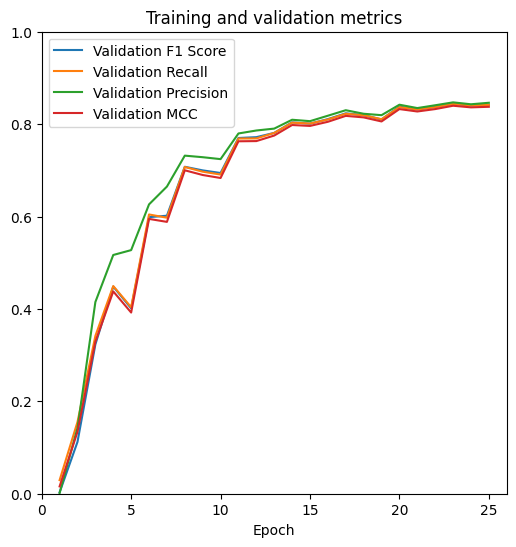

In [25]:
plt.figure(figsize=(6, 6))
plt.plot(range(1, len(val_f1_list) + 1), val_f1_list, label='Validation F1 Score')
plt.plot(range(1, len(val_recall_list) + 1), val_recall_list, label='Validation Recall')
plt.plot(range(1, len(val_precision_list) + 1), val_precision_list, label='Validation Precision')
plt.plot(range(1, len(val_mcc_list) + 1), val_mcc_list, label='Validation MCC')
plt.title(f'Training and validation metrics')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [26]:
print(val_f1_list[-1])
print(val_recall_list[-1])
print(val_precision_list[-1])
print(val_mcc_list[-1])

0.8419226083378649
0.8416149068322981
0.8462145485068543
0.8375058231799694


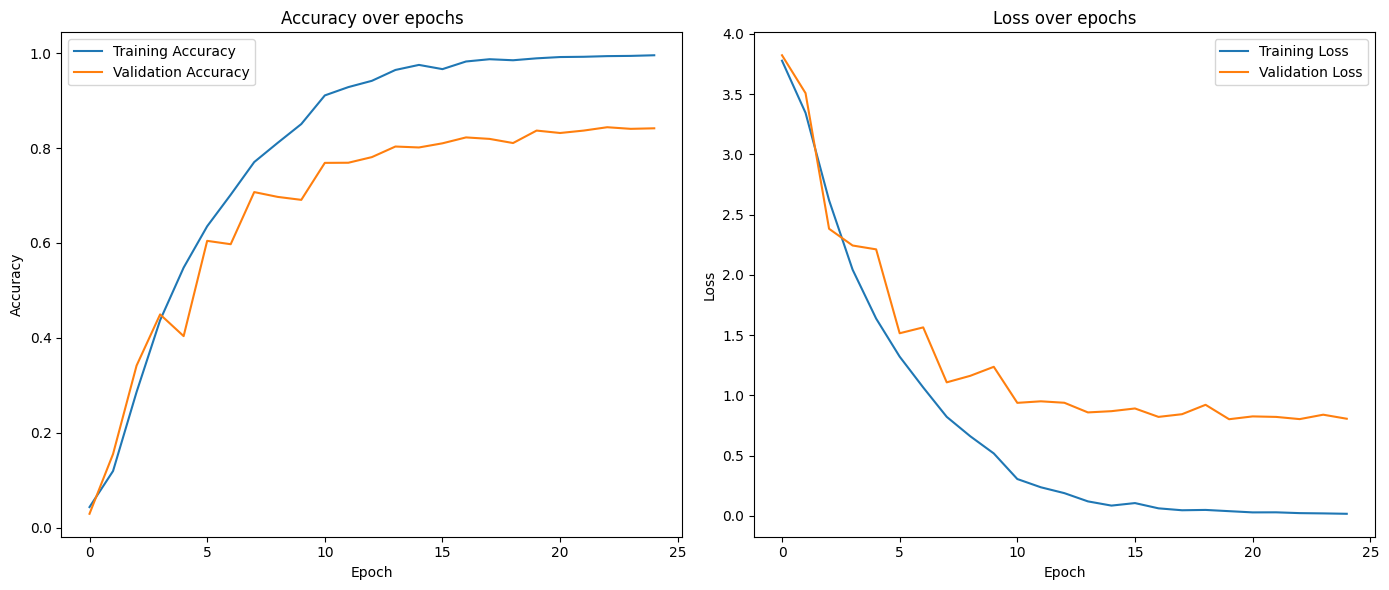

In [18]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [19]:
loaded_model = load_model('./output/models/model_4.keras')
test_loss, test_acc = loaded_model.evaluate(test_generator)
print('Test accuracy: {}%'.format(round(test_acc * 100, 4)))
print('Test loss: {}'.format(test_loss))

111/111 [==============================] - 17s 134ms/step - loss: 0.7076 - accuracy: 0.8584
Test accuracy: 85.8352%
Test loss: 0.7075775265693665


In [20]:
predictions = loaded_model.predict(test_generator)

class_labels = list(test_generator.class_indices.keys())
file_names = test_generator.filenames

results_list = []

for i in range(len(file_names)):
    file_name = file_names[i]
    predicted_class_index = predictions[i].argmax()
    predicted_class = class_labels[predicted_class_index]
    probability = predictions[i][predicted_class_index]
    results_list.append({'File': file_name,
                         'Predicted Class': predicted_class,
                         'Probability': probability})

results_df = pd.DataFrame(results_list)

results_df.head()

111/111 [==============================] - 15s 120ms/step


,File,Predicted Class,Probability
0,./melspectrogram4_dataset/57afd87f-c9de-4a1b-a...,linspa,0.682669
1,./melspectrogram4_dataset/b868f7b2-5a17-42dd-b...,logshr,0.999995
2,./melspectrogram4_dataset/9f8c81d2-d488-4bc2-9...,pinwar,0.821471
3,./melspectrogram4_dataset/e87c105c-f44d-4e7e-9...,comter,0.969563
4,./melspectrogram4_dataset/c168fd0f-8ada-49cd-8...,gockin,0.999988
